In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from sklearn.preprocessing import OneHotEncoder
#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
classes = os.listdir('/content/drive/MyDrive/data_aug/train')

In [ ]:
!pip install Pillow==5.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.9 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.0.1
    Uninstalling Pillow-9.0.1:
      Successfully uninstalled Pillow-9.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.5.2 requires pillow>=6.2.0, but you have pillow 5.3.0 which is incompatible.
lobe 0.6.2 requires pillow~=9.0.1, but you have pillow 5.3.0 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,

        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data_aug/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 5370 images belonging to 3 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data_aug/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)


Found 1340 images belonging to 3 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/data_aug/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 32)

Found 2229 images belonging to 3 classes.


In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(input_shape=(224,224,3),
                   include_top=False,
                   weights="imagenet")

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3,activation='softmax'))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 5, 5, 1536)        0         
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 batch_normalization_203 (Ba  (None, 38400)            153600    
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 32)                1228832   
                                                                 
 batch_normalization_204 (Ba  (None, 32)               1

In [ ]:

def f1_score(y_true, y_pred): #taken from old keras source code
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      recall = true_positives / (possible_positives + K.epsilon())
      f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
      return f1_val

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 5) # when i run it for 50 epochs

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=METRICS)

In [ ]:
history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 10,
                        verbose = 1,
                        callbacks=lr_scheduler)

Epoch 1/10
168/168 [==============================] - 122s 574ms/step - loss: 0.9461 - accuracy: 0.7145 - precision: 0.6200 - recall: 0.3709 - auc: 0.7308 - f1_score: 0.4527 - val_loss: 0.7971 - val_accuracy: 0.7522 - val_precision: 0.6378 - val_recall: 0.5940 - val_auc: 0.8306 - val_f1_score: 0.6149 - lr: 0.0100
Epoch 2/10
168/168 [==============================] - 96s 569ms/step - loss: 0.7557 - accuracy: 0.7821 - precision: 0.7171 - recall: 0.5717 - auc: 0.8403 - f1_score: 0.6351 - val_loss: 0.6052 - val_accuracy: 0.8197 - val_precision: 0.7604 - val_recall: 0.6701 - val_auc: 0.8970 - val_f1_score: 0.7121 - lr: 0.0063
Epoch 3/10
168/168 [==============================] - 92s 550ms/step - loss: 0.6897 - accuracy: 0.8069 - precision: 0.7454 - recall: 0.6389 - auc: 0.8695 - f1_score: 0.6874 - val_loss: 0.5818 - val_accuracy: 0.8323 - val_precision: 0.7841 - val_recall: 0.6858 - val_auc: 0.9064 - val_f1_score: 0.7307 - lr: 0.0040
Epoch 4/10
168/168 [==============================] - 92s

In [ ]:
scores = model.evaluate(test_dataset)

70/70 [==============================] - 559s 8s/step - loss: 0.5789 - accuracy: 0.8108 - precision: 0.7306 - recall: 0.6851 - auc: 0.9068 - f1_score: 0.7069


In [ ]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.8108270764350891
Precision =  0.7306219935417175
Recall =  0.6850605607032776
AUC =  0.906840980052948
F1_score =  0.706902801990509


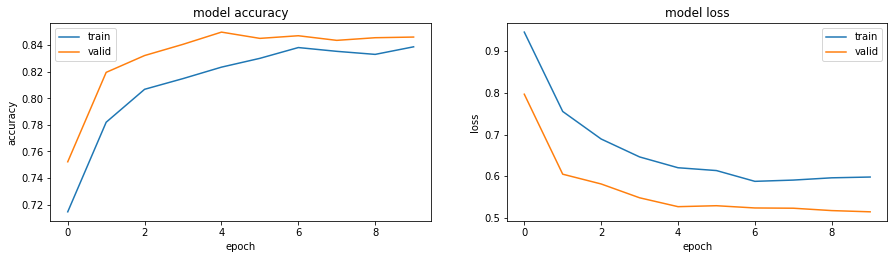

In [ ]:
plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#cd /content/sample_data
!ls

drive  sample_data


In [ ]:
#modeli kaydettik
model.save('/content/sample_data/lungcancertest.h5')

In [ ]:
#gerekli kitaplıkları içe aktardık
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/sample_data/lungcancertest.h5',custom_objects={"f1_score": f1_score})

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_f1_score', 'lr'])


MODEL TEST

In [ ]:
os.listdir("/content/drive/MyDrive/data_aug/train")

['malignant_case', 'normal_case', 'bengin_case']

In [ ]:
train_dir = "/content/drive/MyDrive/data_aug/train"
test_dir = "/content/drive/MyDrive/data_aug/test"
bengin = "/content/drive/MyDrive/data_aug/train/bengin_case"
malignant = "/content/drive/MyDrive/data_aug/train/malignant_case"
normal = "/content/drive/MyDrive/data_aug/train/normal_case"


In [ ]:
#Visualization of Glioma and Meningioma Tumour
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
plt.figure(figsize=(12,6))
gli_samp = random.sample(os.listdir(bengin),5)

for i,image in enumerate(gli_samp):
    path = os.path.join(bengin,image)
    img = load_img(path,target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Bengin Cancer")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout();

plt.figure(figsize=(12,6))
menin_samp = random.sample(os.listdir(malignant),5)

for i,image in enumerate(menin_samp):
    path = os.path.join(malignant,image)
    img = load_img(path,target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("Malignant Cancer")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout();

NameError: ignored

<Figure size 864x432 with 0 Axes>

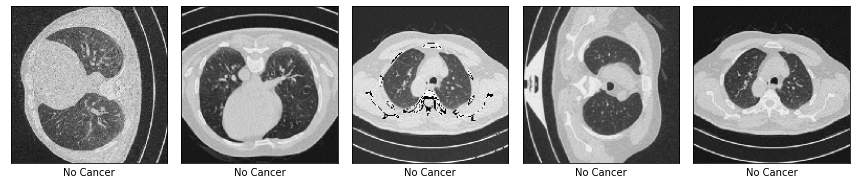

In [ ]:
plt.figure(figsize=(12,6))
no_samp = random.sample(os.listdir(normal),5)

for i,image in enumerate(no_samp):
    path = os.path.join(normal,image)
    img = load_img(path,target_size=(150,150))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.xlabel("No Cancer")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout();

In [ ]:
train_dir = "/content/drive/MyDrive/data_aug/train"
test_dir = "/content/drive/MyDrive/data_aug/test"
train_bengin = "/content/drive/MyDrive/data_aug/train/bengin_case"
train_malignant = "/content/drive/MyDrive/data_aug/train/malignant_case"
train_normal = "/content/drive/MyDrive/data_aug/train/normal_case"

import cv2
X_train = []
y_train = []

for i in tqdm(os.listdir(train_bengin)):
    path = os.path.join(train_bengin,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_train.append(img)
    y_train.append('Bengin')

for i in tqdm(os.listdir(train_malignant)):
    path = os.path.join(train_malignant,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_train.append(img)
    y_train.append('Malignant')

for i in tqdm(os.listdir(train_normal)):
    path = os.path.join(train_normal,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_train.append(img)
    y_train.append('No Cancer')


100%|██████████| 2403/2403 [00:18<00:00, 132.18it/s]


In [ ]:
train_dir = "/content/drive/MyDrive/data_aug/train"
test_dir = "/content/drive/MyDrive/data_aug/test"
test_bengin = "/content/drive/MyDrive/data_aug/train/bengin_case"
test_malignant = "/content/drive/MyDrive/data_aug/train/malignant_case"
test_normal = "/content/drive/MyDrive/data_aug/train/normal_case"

X_test = []
y_test = []

for i in tqdm(os.listdir(test_bengin)):
    path = os.path.join(test_bengin,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append('Bengin')

for i in tqdm(os.listdir(test_malignant)):
    path = os.path.join(test_malignant,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append('Malignant')


for i in tqdm(os.listdir(test_normal)):
    path = os.path.join(test_normal,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    X_test.append(img)
    y_test.append('No Cancer')

100%|██████████| 2403/2403 [00:15<00:00, 155.68it/s]


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train.shape,y_train.shape

((6710, 224, 224, 3), (6710,))

In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test.shape,y_test.shape

((6710, 224, 224, 3), (6710,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


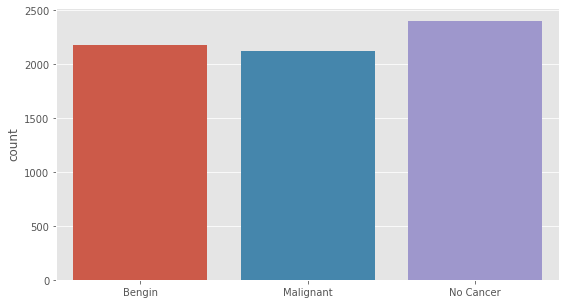

In [ ]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y_train)
plt.show()

In [ ]:
y_train

array(['Bengin', 'Bengin', 'Bengin', ..., 'No Cancer', 'No Cancer',
       'No Cancer'], dtype='<U9')

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
y_train = LE.fit_transform(y_train)

In [ ]:
y_train

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
y_test

array(['Bengin', 'Bengin', 'Bengin', ..., 'No Cancer', 'No Cancer',
       'No Cancer'], dtype='<U9')

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [ ]:
y_test

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
unique,counts = np.unique(y_train,return_counts=True)
print(unique,counts)

[0 1 2] [2184 2123 2403]


In [ ]:
unique1,counts1 = np.unique(y_test,return_counts=True)
print(unique1,counts1)

[0 1 2] [2184 2123 2403]


In [ ]:
y_train = to_categorical(y_train)#num_classes = 4
y_train.shape

(6710, 3)

In [ ]:
y_test = to_categorical(y_test)#num_classes = 4
y_test.shape

(6710, 3)

In [ ]:
img_size=224
train_datagen = ImageDataGenerator(rotation_range=30,height_shift_range=0.2,
                                  zoom_range = 0.3,horizontal_flip=True)#rescale=(1./255),
test_datagen = ImageDataGenerator()#rescale=(1./255)

train_gen = train_datagen.flow_from_directory(directory = train_dir,target_size=(img_size,img_size),class_mode ="categorical",
                                              batch_size=32)
test_gen = test_datagen.flow_from_directory(directory = test_dir,target_size=(img_size,img_size),class_mode ="categorical",
                                              batch_size=32)

Found 6710 images belonging to 3 classes.
Found 2229 images belonging to 3 classes.


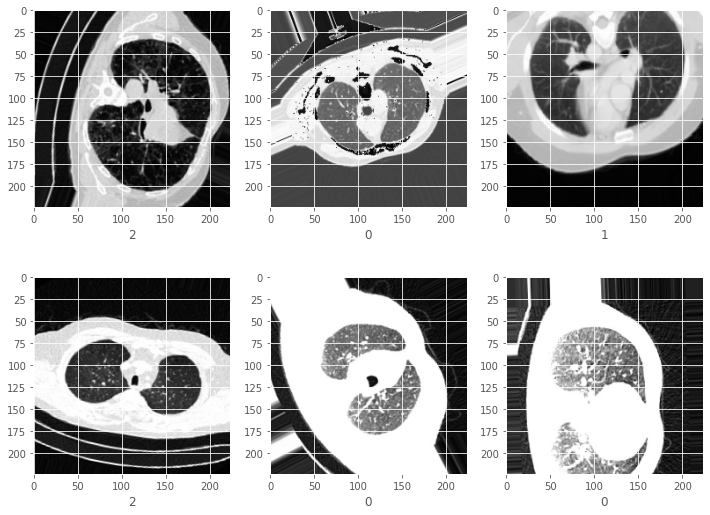

In [ ]:
from tensorflow.keras.preprocessing import image
sample_x,sample_y = next(train_gen)
plt.figure(figsize=(12,9))
for i in range(6):
    plt.subplot(2,3,i+1)
    sample = image.array_to_img(sample_x[i])
    plt.xlabel(np.argmax(sample_y[i]))
    plt.imshow(sample)
plt.show()

In [ ]:
y_pred= model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_pred[:15]

array([2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2])

In [ ]:
unique,counts = np.unique(y_pred,return_counts=True)
print(unique,counts)

[0 2] [3659 3051]


In [ ]:
y_test_new = np.argmax(y_test,axis=1)

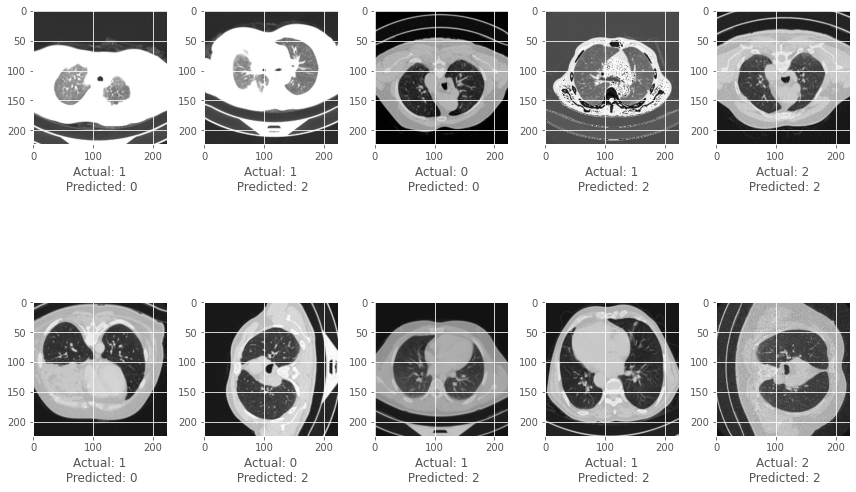

In [ ]:
plt.figure(figsize=(12,9))
for i in range(10):
    sample_idx = random.choice(range(len(X_test)))
    plt.subplot(2,5,i+1)
    plt.imshow(X_test[sample_idx])
    plt.xlabel(f"Actual: {y_test_new[sample_idx]}\n Predicted: {y_pred[sample_idx]}")

plt.tight_layout()
plt.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)


In [ ]:

accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

In [ ]:
train_pred = new_model.predict(X_train)
train_pred = np.argmax(train_pred, axis=1)
Y_train_ = np.argmax(y_train, axis=1)
print("Accuracy on training set: {:.2f}%".format(np.sum(train_pred==Y_train_)/len(Y_train_)*100))

Accuracy on training set: 32.55%
